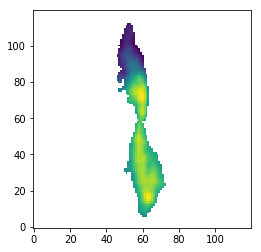

In [3]:
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.insert(0, "..")
from stamp import *
from physics import *
%load_ext autoreload
%autoreload 2

c12 = SpectralCube.read("../../cubes/mask_imfit_12co_pix_2_Tmb.fits")
t_hops = Table.read("../../catalogs/hops.fits")

hops_id = 169
hops = t_hops[t_hops["HOPS"] == hops_id][0]
coord = SkyCoord(hops["RAJ2000"], hops["DEJ2000"], unit=u.deg)
vblue = 4.7*u.km/u.s, 10*u.km/u.s

width=height=4*u.arcmin

sub12 = extract_subcube(c12, region_class=RectangleSkyRegion,
                      region_kwargs=dict(center=coord, width=width, height=height))

mask_outflow = np.load("mask_outflow.npy")
sub12_outflow = sub12.with_mask(mask_outflow)
plt.imshow(sub12_outflow.moment0().data, origin='lower')

Guess an initial outflow angle (Dunham correspondence), then fit a guassian to the distribution of outflow pixel angles from this initial guess. The mean of the gaussian is the position angle and the full-width-quarter maximum (find the Offner (11?) citation for this) is the opening angle.

3.025278820904256 rad


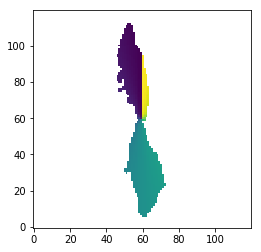

In [4]:
pa_init = 0*u.deg
coord_zero = coord
dec, ra = sub12_outflow.spatial_coordinate_map
dec = dec - coord_zero.dec
ra = ra - coord_zero.ra
pa = np.arctan(ra/dec)

pa[dec < 0] = np.arctan(ra[dec<0]/dec[dec<0]) + (np.pi)*u.rad
pa[(dec > 0) & (ra<0)] = np.arctan(ra[(dec > 0) & (ra<0)]/dec[(dec > 0) & (ra<0)]) + 2*(np.pi)*u.rad

# plt.imshow(pa.value, origin='lower')

pa[~mask_outflow] = np.nan
# plt.imshow(pa.value, origin='lower')
print(np.nanmedian(pa))
pa_init = np.nanmedian(pa)
plt.imshow((pa - pa_init).value, origin='lower')
# plt.colorbar()
# plt.colorbar()

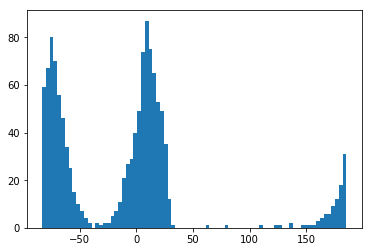

In [5]:
pa_delt = pa - pa_init
pa_delt[pa_delt.value < -np.pi/2] = pa_delt[pa_delt.value < -np.pi/2] + u.rad*np.pi/2
bins = plt.hist((pa_delt).flatten().value*180/np.pi, bins=80)

We need to separate the two outflow lobes so that we don't have to worry about the angle going all the way around the 
unit circle.

-6.647722161912544 deg
84.15033426874248 deg
84d09m01.8s


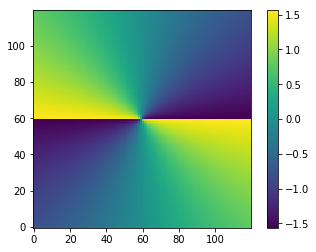

In [6]:
mask_bluelobe = np.load("mask_bluelobe.npy")

pa_init = 0*u.deg
coord_zero = coord
dec, ra = sub12_outflow.spatial_coordinate_map
dec = dec - coord_zero.dec
ra = ra - coord_zero.ra
pa = np.arctan(ra/dec)

print(np.mean(sub12_outflow.latitude_extrema))
print(np.mean(sub12_outflow.longitude_extrema))

print(coord.ra)

# pa[dec < 0] = pa[dec<0] + (np.pi)*u.rad
# pa[(dec > 0) & (ra<0)] = pa[(dec > 0) & (ra<0)] + 2*(np.pi)*u.rad
plt.imshow(pa.value, origin='lower')
plt.colorbar()

0.16855493857504802 rad
197896.078125 K m / s
0.0156108rad
0.49999999999999994
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]] deg


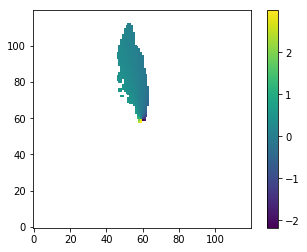

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [7]:
pa[~mask_bluelobe] = np.nan
print(np.nanmedian(pa))
pa_init = np.nanmedian(pa)

# plt.imshow((pa-pa_init).value, origin='lower')
# vec = (ra, dec)
mom0_blue = sub12.with_mask(mask_bluelobe).moment0()
print(np.nanmax(mom0_blue))
ra_peak = ra[mom0_blue == np.nanmax(mom0_blue)][0]
dec_peak = dec[mom0_blue == np.nanmax(mom0_blue)][0]
vec_peak = ra_peak,dec_peak
vec = (ra_peak.value, dec_peak.value)
# np.dot(vec, (ra.flatten(), dec.flatten()))
arr = np.arctan2(ra, dec)
# plt.imshow(np.arctan2(ra, dec).value, origin='lower')
theta = np.arctan2(ra_peak, dec_peak)
print(theta.to(u.radian))
# theta = 1.5*np.pi
c, s = np.cos(theta), np.sin(theta)
R = np.array([[c,-s], [s, c]])

rot = R.dot(np.array([ra.flatten(),dec.flatten()]))
rot_ra, rot_dec = rot.reshape(np.array([ra,dec]).shape)
# plt.imshow(np.arctan2(rot_ra, rot_dec), origin='lower')
# plt.colorbar()
# plt.show()
print(np.sin(30*u.deg))
pa = np.arctan2(rot_ra, rot_dec)
pa[~mask_bluelobe] = np.nan
print(pa*u.deg)
plt.imshow(pa, origin='lower')
plt.colorbar()
plt.show()
print(~np.isnan(sub12.with_mask(mask_bluelobe)[0]))

Guessing these parameters:  {'amplitude': 0.04054052167920455, 'mean': 5.561325238240528, 'stddev': 125.01425464169075}
[[ 5.48045824e-07 -5.19073422e-20 -1.03770989e-04]
 [-5.19073422e-20  5.89462654e-02  2.00924487e-17]
 [-1.03770989e-04  2.00924487e-17  5.89462654e-02]]
Opening Angle: 34 degrees
Postion Angle: 10 degrees


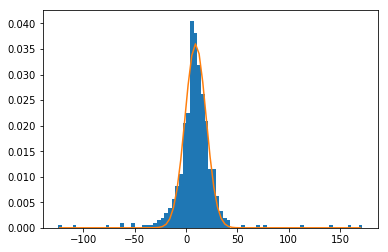

In [8]:
from astropy.visualization import hist as astro_hist

hist, bin_edges, patches = astro_hist(pa[mask_bluelobe].flatten()*180/np.pi, 'knuth', normed=True)
bin_centers = np.array([0.5 * (bin_edges[i] + bin_edges[i+1]) for i in range(len(bin_edges)-1)])

g = fit_gaussian(bin_centers, hist, autoguess=True)
plt.plot(bin_centers, g(bin_centers))
fwqm = 3.3302*g.stddev
print("Opening Angle: {:.2g}".format(fwqm), "degrees")
print("Postion Angle: {:.2g}".format(theta.to(u.deg).value + g.mean), "degrees")

Guessing position angle of 2.2578807301177677 deg
Guessing these parameters:  {'amplitude': 80.0, 'mean': 6.359368034839363, 'stddev': 138.47378130867486}
[[ 1.76064020e+00  3.65263092e-17 -1.70620153e-01]
 [ 3.65263092e-17  4.96033829e-02 -1.30960339e-17]
 [-1.70620153e-01 -1.30960339e-17  4.96033829e-02]]
10.749527748653067 deg 33.4901517941853 deg


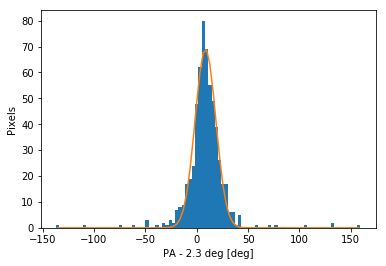

In [46]:
pa, oa = outflow_angles(sub12.with_mask(mask_bluelobe), autoguess=True, plot=True)
print(pa, oa)